In [1]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_learning_curves
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTENC
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
# from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import re

In [2]:
x_train_original = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_train.csv", 
                               index_col = False, delimiter = ',', header=0)

In [3]:
train_label = x_train_original.loc[:,'duration_label']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x_train_original.drop(columns="duration_label"),train_label, test_size=0.2, stratify=train_label, random_state=42)


### Oversample the training data using oversampling. Test data is not oversampled

In [5]:
### Implement oversampling
X_train.shape
oversample = RandomOverSampler(sampling_strategy='minority')
# First random oversampling, bring count of class 3 to be equal to the highest class count.
X_oversampled, y_oversampled = oversample.fit_resample(X_train, y_train)
# Second random oversampling, bring the count of class 2 to be equal to the other 2 classes
X_oversampled, y_oversampled = oversample.fit_resample(X_oversampled, y_oversampled)

y_oversampled.value_counts()

2.0    16197
3.0    16197
1.0    16197
Name: duration_label, dtype: int64

### Transforming data into a bag of words and use countvec transformation

In [6]:
# train_corpus = x_train_original.drop(columns='duration_label')
# train_corpus
train_corpus = pd.DataFrame(X_oversampled)
train_corpus

,name,n_steps,n_ingredients,steps,ingredients
0,couve brazilian style collard greens,6,2,"['wash the collard greens', 'remove the stems ...","['collard greens', 'butter']"
1,dijon mustard marinade for grilled fish,6,6,"['mix all ingredients well', 'to prepare your ...","['butter', 'dijon mustard', 'dry white wine', ..."
2,kathy 3 dry cooked green beans zwt ii asia,5,11,['cut green beans into 2 1 / 2 inch sections &...,"['fresh green beans', 'ground pork', 'dried sh..."
3,jumbo chicken salad stuff ems,8,5,"['preheat oven to 375f', 'mix chicken , cheese...","['cooked chicken', 'fat free cheese', 'green o..."
4,b b q d corn with chilli lime butter,3,6,['plunge the cobs of corn into water and then ...,"['corn', 'butter', 'lime', 'chili', 'garlic', ..."
...,...,...,...,...,...
48586,apple cinnamon mug cake,5,7,"['mix every ingredients in bowl', 'pour in a m...","['oatmeal', 'sugar', 'cinnamon', 'baking powde..."
48587,back in the ussr salad dressing,2,6,"['mix em up', 'cover and chill']","['miracle whip', 'lemon juice', 'sweet relish'..."
48588,salsa for one,2,5,"['mix well', 'dip in your chips and enjoy !']","['tomatoes', 'diced green chilies', 'onion', '..."
48589,scallops with tangy honey glaze,6,9,"['sprinkle scallops with salt and pepper', 'br...","['sea scallops', 'salt', 'pepper', 'olive oil'..."


In [7]:
test_corpus = pd.DataFrame(X_test)
# Joining columns for test
test_corpus['steps'] = test_corpus['steps'].apply(eval)
test_corpus['ingredients'] = test_corpus['ingredients'].apply(eval)
test_corpus['steps'] = test_corpus['steps'].apply(' '.join)
test_corpus['ingredients'] = test_corpus['ingredients'].apply(' '.join)

In [8]:
train_corpus['steps'] = train_corpus['steps'].apply(eval)
train_corpus['ingredients'] = train_corpus['ingredients'].apply(eval)
train_corpus['steps'] = train_corpus['steps'].apply(' '.join)
train_corpus['ingredients'] = train_corpus['ingredients'].apply(' '.join)



In [9]:
train_corpus

,name,n_steps,n_ingredients,steps,ingredients
0,couve brazilian style collard greens,6,2,wash the collard greens remove the stems and r...,collard greens butter
1,dijon mustard marinade for grilled fish,6,6,mix all ingredients well to prepare your fish ...,butter dijon mustard dry white wine dried tarr...
2,kathy 3 dry cooked green beans zwt ii asia,5,11,cut green beans into 2 1 / 2 inch sections & c...,fresh green beans ground pork dried shrimp gar...
3,jumbo chicken salad stuff ems,8,5,"preheat oven to 375f mix chicken , cheese , on...",cooked chicken fat free cheese green onions lo...
4,b b q d corn with chilli lime butter,3,6,plunge the cobs of corn into water and then pl...,corn butter lime chili garlic salt & freshly g...
...,...,...,...,...,...
48586,apple cinnamon mug cake,5,7,mix every ingredients in bowl pour in a mug ba...,oatmeal sugar cinnamon baking powder apple mil...
48587,back in the ussr salad dressing,2,6,mix em up cover and chill,miracle whip lemon juice sweet relish no-salt-...
48588,salsa for one,2,5,mix well dip in your chips and enjoy !,tomatoes diced green chilies onion garlic powd...
48589,scallops with tangy honey glaze,6,9,sprinkle scallops with salt and pepper brush w...,sea scallops salt pepper olive oil margarine h...


In [10]:
all_words = []

for i in range (0, len(train_corpus['steps'])):
    s = ''
    s += train_corpus.loc[i,'name'] + train_corpus.loc[i, 'steps'] + train_corpus.loc[i, 'ingredients']
    all_words.append(s)

all_words

['couve brazilian style collard greenswash the collard greens remove the stems and roll the leaves tightly together slice into very thin strips with a sharp knife just before serving , melt the butter and add collard greens cook over high heat stirring constantly until collard greens just start to wilt sprinkle with salt and servecollard greens butter',
 'dijon mustard marinade for grilled fishmix all ingredients well to prepare your fish , marinate your fish fillets for several hours prepare your grill once it is hot , grill your fish until it flakes easily baste the fish with the marinade while it is grilling delish !butter dijon mustard dry white wine dried tarragon salt white pepper',
 'kathy  3   dry cooked green beans  zwt ii   asiacut green beans into 2 1 / 2 inch sections & chop shrimp deep fry green beans at around 350 degrees for 10 min & drain well stir fry pork , shrimp & garlic in 1 tbsp oil for 2 minutes then add beans & rest of ingredients except green onion & sesame oil

In [11]:
test_corpus = test_corpus.reset_index()
all_words_test = []

for j in range (0, len(test_corpus['steps'])):
#     print(j)
    s = ''
    s += test_corpus.loc[j,'name'] + test_corpus.loc[j, 'steps'] + test_corpus.loc[j, 'ingredients']
    all_words_test.append(s)
    
all_words_test

['curried broccolipour 2" of water into a large pot place a collapsible steamer in the pot , cover , and bring water to a boil place the broccoli florets in steamer , cover and steam 5 minutes , or till tender-crisp meanwhile , in a large nonstick skillet , bring the orange and lemon juices to a boil over medium high heat reduce the juices down to 1 / 4 cup turn down heat to low and stir in butter and curry powder stir in the cooked broccoli florets and heat through move to a serving dish and season to taste with pepper to taste serve immediately and enjoy !broccoli fresh orange juice fresh lemon juice butter curry powder fresh ground black pepper',
 'chicken with sourdough mushroom stuffinglightly coat the inside of a 5-1 / 2- to 6-quart slow cooker with cooking spray reserve 1 teaspoon of the lemon peel in a small bowl combine remaining lemon peel , sage , seasoned salt and pepper remove 3 / 4 of the mixture and rub onto chicken legs place chicken in slow cooker melt butter in a skil

In [12]:
# Best max_features=10000
# vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=50000)
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), strip_accents='unicode', max_features=50000)
X_vec = vectorizer.fit(all_words)
X = vectorizer.transform(all_words)
X.shape

X_t = vectorizer.transform(all_words_test)
X.shape, X_t.shape

((48591, 50000), (8000, 50000))

In [13]:
vocab = vectorizer.vocabulary_
vocab

{'brazilian': 4755,
 'style': 44122,
 'collard': 9610,
 'greens': 19025,
 'remove': 35608,
 'stems': 43128,
 'roll': 36710,
 'leaves': 23074,
 'tightly': 45928,
 'slice': 40676,
 'strips': 44045,
 'sharp': 39746,
 'knife': 22503,
 'just': 22201,
 'serving': 39346,
 'melt': 25421,
 'butter': 5913,
 'add': 822,
 'cook': 10281,
 'high': 20103,
 'heat': 19680,
 'stirring': 43618,
 'constantly': 10119,
 'start': 42921,
 'wilt': 49339,
 'sprinkle': 42572,
 'salt': 37308,
 'collard greens': 9611,
 'remove stems': 35778,
 'slice strips': 40737,
 'sharp knife': 39750,
 'just serving': 22287,
 'serving melt': 39378,
 'melt butter': 25423,
 'butter add': 5922,
 'greens cook': 19027,
 'cook high': 10359,
 'high heat': 20128,
 'heat stirring': 19916,
 'stirring constantly': 43638,
 'just start': 22300,
 'sprinkle salt': 42689,
 'dijon': 13663,
 'mustard': 27847,
 'marinade': 24712,
 'grilled': 19121,
 'ingredients': 21311,
 'prepare': 34116,
 'fish': 16340,
 'marinate': 24791,
 'fillets': 16117,
 '

### Can try TruncatedSVD, PCA does not support sparse matrices

In [15]:
full_train = x_train_original.drop(columns="duration_label")

In [16]:
full_train['steps'] = full_train['steps'].apply(eval)
full_train['ingredients'] = full_train['ingredients'].apply(eval)
full_train['steps'] = full_train['steps'].apply(' '.join)
full_train['ingredients'] = full_train['ingredients'].apply(' '.join)



In [17]:
full_set = []

for i in range (0, len(full_train['steps'])):
    s = ''
    s += full_train.loc[i,'name'] + full_train.loc[i, 'steps'] + full_train.loc[i, 'ingredients']
    full_set.append(s)

### full_X is the countvec form of the entire original training set! USE THIS FOR ALL GRID SEARCH!

full_X is original training data   
train_label is the original training label

In [25]:
vfull = CountVectorizer(stop_words='english', ngram_range=(1,2), strip_accents='unicode')
full_vec = vfull.fit(full_set)
full_X = vfull.transform(full_set)


In [19]:
full_vocab = vfull.vocabulary_
full_vocab

{'wi': 652341,
 'gal': 244511,
 'chicken': 104987,
 'rice': 474527,
 'stove': 574402,
 'dish': 185704,
 'healthierin': 270228,
 'saucepan': 498712,
 'melt': 345605,
 'margarine': 335890,
 'combine': 131984,
 'olive': 384768,
 'oil': 382197,
 'add': 11685,
 'celery': 95504,
 'onion': 386461,
 'saute': 501336,
 'tender': 595939,
 'garlic': 245065,
 'minute': 353399,
 'carrots': 91857,
 'broth': 70869,
 'pepper': 414579,
 'bring': 68747,
 'boil': 57611,
 'reduce': 463896,
 'heat': 270927,
 'cover': 150210,
 'simmer': 530338,
 '35': 5853,
 'minutes': 354239,
 'stir': 570169,
 'parsley': 404029,
 'longer': 327864,
 'heated': 272422,
 'throughmargarine': 602984,
 'clove': 124140,
 'low': 329724,
 'sodium': 544897,
 'brown': 71734,
 'salt': 491913,
 'substitute': 579610,
 'boneless': 59191,
 'skinless': 534892,
 'breasts': 67327,
 'fresh': 237892,
 'wi gal': 652343,
 'gal chicken': 244512,
 'chicken rice': 106832,
 'rice stove': 475846,
 'stove dish': 574474,
 'dish healthierin': 186122,
 'he

In [76]:
# Selecting best feature from the original data set, 
# countvec it and then use its dictionary for the entire dataset as countvec

### START OF DONT RUNN BARRIER -------------------------------------------------------------------------------------------------------

In [63]:

## Attempt at selecting features with words indicating time.
dictionary = []
for w in full_vocab.keys():
    if (re.match("\d+ minutes", w) != None or re.match("\d+ minute", w) != None):
        dictionary.append(w)
    if (re.match("\d+ hours", w) != None or re.match("\d+ hour", w) != None):
        dictionary.append(w)
    if (re.match("\d+ second", w) != None or re.match("\d+ seconds", w) != None):
        dictionary.append(w)
        
# remove duplicates
dictionary = list( dict.fromkeys(dictionary) )
len(dictionary)

1313

In [ ]:
#

In [64]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), strip_accents='unicode', vocabulary=dictionary)
X_vec = vectorizer.fit(all_words)
X = vectorizer.transform(all_words)
X.shape

X_t = vectorizer.transform(all_words_test)
X.shape, X_t.shape

((48591, 1313), (8000, 1313))

### END OF DONT RUNN BARRIER -------------------------------------------------------------------------------------------------------

In [20]:
t_svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
truncated_full = t_svd.fit_transform(full_X)

In [21]:
truncated_full.shape
truncated_full = pd.DataFrame(truncated_full)
truncated_full

,0,1
0,5.751262,-4.119799
1,5.543845,-0.052968
2,5.784392,0.105748
3,3.712576,-0.681911
4,1.501898,1.647080
...,...,...
39995,3.495807,2.793423
39996,9.655074,-1.776283
39997,3.932288,-2.544716
39998,6.751920,-2.334800


### Visualising the data with TruncatedSVD
outliers spotted   
No clear cluster for label 3 as expected, could be due to low number of label 3 instances.   
Cluster of 1 is very close to cluster of 2

Clusters are very close, and unclear cluster for label 3. Hence KNN will not be very useful for this dataset.

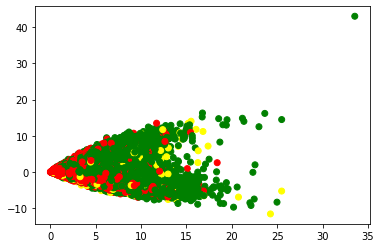

In [22]:
colors = {1:'red', 2:'green', 3:'yellow'}

fig, ax = plt.subplots()
ax.scatter(truncated_full.iloc[:,0], truncated_full.iloc[:,1], c=train_label.map(colors))

### Grid Search Function

In [133]:
# def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
#                        model, param_grid, cv, scoring_fit,
#                        do_probabilities = False):
#     gs = GridSearchCV(
#         estimator=model,
#         param_grid=param_grid, 
#         cv=cv, 
#         n_jobs=-1, 
#         scoring=scoring_fit,
#         verbose=2
#     )
#     fitted_model = gs.fit(X_train_data, y_train_data)
    
#     if do_probabilities:
#         pred = fitted_model.predict_proba(X_test_data)
#     else:
#         pred = fitted_model.predict(X_test_data)

#     return fitted_model, pred

### Logistic Regression
current best: Logclf = LogisticRegression(C=0.008, max_iter=5000, random_state=0, solver=saga)
Recommended by gridsearchCV: {'C': 0.1}

In [23]:
Logclf = LogisticRegression(C=0.1, max_iter=5000, random_state=0, solver='saga')
clf = make_pipeline(MaxAbsScaler(),Logclf)

clf.fit(X, y_oversampled)

y_pred = clf.predict(X_t)
y_train_pred = clf.predict(X)

print("test:", accuracy_score(y_test, y_pred))
print("train:", accuracy_score(y_oversampled, y_train_pred))
# print('scoring:', clf.score(X_t, y_test))
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
cm

test: 0.786875
train: 0.9605070897902904
              precision    recall  f1-score   support

         1.0       0.75      0.83      0.79      3541
         2.0       0.83      0.77      0.80      4049
         3.0       0.75      0.65      0.70       410

    accuracy                           0.79      8000
   macro avg       0.77      0.75      0.76      8000
weighted avg       0.79      0.79      0.79      8000



array([[2922,  573,   46],
       [ 898, 3106,   45],
       [  77,   66,  267]], dtype=int64)

### Logistic Regression Learning Curve

### Logistic Regression Hyperparameter tuning and CV result
This uses the full training set   

Output of box below:   
Fitting 5 folds for each of 12 candidates, totalling 60 fits   
0.8764586400809865   
{'C': 0.1}

In [ ]:
param_LogReg = {
    # Comparing previous gridCV best of 0.1 to what we found to be best. 0.1 is still better on the training set.
    'C': np.logspace(-10, 2, 100)
}

# X_scaled = MaxAbsScaler().fit_transform(X)
# X_t_scaled = MaxAbsScaler().fit_transform(X_t)
# model, pred = algorithm_pipeline(X_scaled, X_t_scaled, y_oversampled, y_test, 
#                        Logclf, param_LogReg, cv=5, scoring_fit='accuracy',
#                        do_probabilities = False)


# print(model.best_score_)
# print(model.best_params_)


X_scaled = MaxAbsScaler().fit_transform(full_X)
gridCV = GridSearchCV(Logclf, param_LogReg, n_jobs=-1)

gridCV.fit(X_scaled, train_label)
# gridCV.best_params_
print(gridCV.best_score_)
print(gridCV.best_params_)

In [154]:
print("current acc:", accuracy_score(y_test, pred))

current acc: 0.78625


In [155]:
logReg_gs = pd.DataFrame(gridCV.cv_results_)
logReg_gs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,11.819877,0.198036,0.007116,0.001444,0.008,{'C': 0.008},0.849882,0.845339,0.849043,0.845236,0.852027,0.848305,0.002650,2
1,33.629254,0.170628,0.005775,0.000392,0.1,{'C': 0.1},0.874678,0.867771,0.875180,0.872402,0.892262,0.876459,0.008324,1


### LinearSVC
best C: 0.005 or 0.053366992312063016

In [24]:
LinearSVC_clf = svm.LinearSVC(C=0.053366992312063016,dual=False, multi_class='ovr',random_state=0)
SVC_clf = make_pipeline(MaxAbsScaler(), LinearSVC_clf)
SVC_clf.fit(X, y_oversampled)

y_test_predict = SVC_clf.predict(X_t)
y_train_predict = SVC_clf.predict(X)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_oversampled, y_train_predict))
print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.775125
0.9859233191331728
              precision    recall  f1-score   support

         1.0       0.74      0.81      0.77      3541
         2.0       0.81      0.77      0.79      4049
         3.0       0.80      0.57      0.67       410

    accuracy                           0.78      8000
   macro avg       0.78      0.72      0.74      8000
weighted avg       0.78      0.78      0.77      8000



array([[2869,  640,   32],
       [ 924, 3098,   27],
       [  85,   91,  234]], dtype=int64)

### LinearSVC Learning Curve

MaxAbsScaler()

### LinearSVC HyperParameter tuning

GridsearchCV on C parameter shows {'C': 0.053366992312063016}   
Best score (Mean cross-validated score of the best_estimator): 0.8593566754087872

In [67]:
# Grid search
parameters = {'C': np.logspace(-10, 2, 100)}


svc = svm.LinearSVC(dual=False, multi_class='ovr',random_state=0)

# X_scaled = MaxAbsScaler().fit_transform(X)
X_scaled = MaxAbsScaler().fit_transform(full_X)
gridCV = GridSearchCV(svc, parameters, n_jobs=-1)

gridCV.fit(X_scaled, train_label)
print(gridCV.best_score_)
print(gridCV.best_params_)

{'C': 0.053366992312063016}

In [156]:
cv_result = pd.DataFrame(gridCV.cv_results_)
cv_result
graph_df = cv_result.loc[:,['param_C','mean_test_score']]
graph_df

,param_C,mean_test_score
0,0.0,0.588751
1,0.0,0.588751
2,0.0,0.588751
3,0.0,0.588751
4,0.0,0.588751
...,...,...
95,32.745492,0.838715
96,43.287613,0.838221
97,57.223677,0.838283
98,75.646333,0.837830


In [38]:

plt.plot(graph_df.iloc[:,0], graph_df.iloc[:,1])
plt.xlabel('param_C')
plt.ylabel('mean_test_score')
# plt.legend()
plt.show()

NameError: name 'graph_df' is not defined

### SGD Classifier

In [73]:
clf_SGD = SGDClassifier(alpha=0.001,max_iter=1000, tol=1e-3, n_jobs=6, random_state=0)
SGD = make_pipeline(MaxAbsScaler(),clf_SGD)
SGD.fit(X, y_oversampled)

y_test_predict_SGD = SGD.predict(X_t)
y_train_predict_SGD = SGD.predict(X)
print(accuracy_score(y_test, y_test_predict_SGD))
print(accuracy_score(y_oversampled, y_train_predict_SGD))


print(classification_report(y_test, y_test_predict_SGD))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.42275
0.5132843530694985
              precision    recall  f1-score   support

         1.0       0.60      0.06      0.11      3541
         2.0       0.75      0.71      0.73      4049
         3.0       0.08      0.73      0.14       410

    accuracy                           0.42      8000
   macro avg       0.48      0.50      0.33      8000
weighted avg       0.65      0.42      0.43      8000



array([[3173,  321,   47],
       [1594, 2378,   77],
       [ 280,   72,   58]], dtype=int64)

### SGD Classifier Learning Curve

### SGD Classifier HyperParameter Tuning

### Random Forest

In [74]:
forest = RandomForestClassifier(n_estimators=2000, max_features='auto', max_depth=6, 
                                criterion='gini', n_jobs = -1, random_state = 0)
forest.fit(X, y_oversampled)

y_test_predict = forest.predict(X_t)
y_train_predict = forest.predict(X)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_oversampled, y_train_predict))


print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.694
0.5499989710028607
              precision    recall  f1-score   support

         1.0       0.63      0.85      0.72      3541
         2.0       0.81      0.62      0.70      4049
         3.0       0.46      0.13      0.20       410

    accuracy                           0.69      8000
   macro avg       0.63      0.53      0.54      8000
weighted avg       0.71      0.69      0.68      8000



array([[3007,  508,   26],
       [1521, 2492,   36],
       [ 274,   83,   53]], dtype=int64)

### Random Forest Hyperparameter Tuning

Exhaustive grid search gives:
{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 2000}

In [56]:
# Grid search
param_grid = { 
    'n_estimators': [100,200, 300, 400, 500, 1000, 1500, 2000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10],
    'criterion' :['gini', 'entropy']
}
# CV_rfc = RandomizedSearchCV(estimator=forest, param_distributions =param_grid, n_iter=10, cv= 4, random_state=0, n_jobs = -1)
CV_rfc = GridSearchCV(estimator=forest, param_grid=param_grid, n_jobs=-1)
CV_rfc.fit(X,y_oversampled)
CV_rfc.best_params_


{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 2000}

### Random Forest Learning Curve

In [47]:
test_y = []
train_y = []

for depth in range(1,11):
    forest = RandomForestClassifier(n_estimators=500, max_features='auto', max_depth=depth, 
                                criterion='gini', n_jobs = -1, random_state = 0)
    
    forest.fit(X, y_oversampled)
    Forest_pred = forest.predict(X_t)
    Forest_train_pred = forest.predict(X)
    
    test_y.append(accuracy_score(y_test, Forest_pred))
    train_y.append(accuracy_score(y_oversampled, Forest_train_pred))
    

acc = {
    'test_y': test_y,
    'train_y': train_y
}


acc_df = pd.DataFrame(acc, columns = ['test_y','train_y'])
acc_df

,test_y,train_y
0,0.718000,0.685888
1,0.726625,0.705378
2,0.727625,0.708403
3,0.731375,0.717067
4,0.741000,0.731308
5,0.743125,0.742380
6,0.747625,0.750942
7,0.752875,0.767838
8,0.753500,0.776337
9,0.758125,0.790311


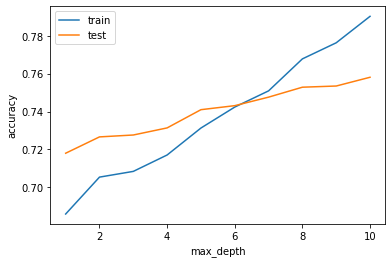

In [48]:
depth = [1,2,3,4,5,6,7,8,9,10]

plt.plot(depth, train_y, label = "train")
plt.plot(depth, test_y, label = "test")
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

### Boosting

In [37]:
Adaboost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,random_state=0), n_estimators=100, random_state=0)
Adaboost.fit(X, y_oversampled)

y_test_predict = Adaboost.predict(X_t)
y_train_predict = Adaboost.predict(X)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_oversampled, y_train_predict))


print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.725125
0.7710275565433928
              precision    recall  f1-score   support

         1.0       0.72      0.73      0.73      3541
         2.0       0.78      0.71      0.74      4049
         3.0       0.47      0.79      0.59       410

    accuracy                           0.73      8000
   macro avg       0.66      0.74      0.69      8000
weighted avg       0.74      0.73      0.73      8000



array([[2590,  779,  172],
       [ 967, 2889,  193],
       [  45,   43,  322]], dtype=int64)

### Stacking Classifier

### Stacking evaluation

In [173]:
estimators = [
     ('LinearSVC', SVC_clf),
     ('SGD', SGD),
    ('LogisticRegression', clf)]

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(n_jobs=-1, random_state=0), n_jobs=-1)
stacking_clf.fit(X, y_oversampled)
y_test_predict = stacking_clf.predict(X_t)
y_train_predict = stacking_clf.predict(X)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_oversampled, y_train_predict))


print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm

0.790125
0.9945874750468193
              precision    recall  f1-score   support

         1.0       0.76      0.82      0.79      3541
         2.0       0.81      0.80      0.80      4049
         3.0       0.93      0.41      0.57       410

    accuracy                           0.79      8000
   macro avg       0.84      0.68      0.72      8000
weighted avg       0.80      0.79      0.79      8000



array([[2910,  622,    9],
       [ 805, 3241,    3],
       [  96,  144,  170]], dtype=int64)

### Testing on Real Test data

In [174]:
x_test_original = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_test.csv", 
                               index_col = False, delimiter = ',', header=0)
x_test_original
x_test_original['steps'] = x_test_original['steps'].apply(eval)
x_test_original['ingredients'] = x_test_original['ingredients'].apply(eval)
x_test_original['steps'] = x_test_original['steps'].apply(' '.join)
x_test_original['ingredients'] = x_test_original['ingredients'].apply(' '.join)
x_test_original

,name,n_steps,n_ingredients,steps,ingredients
0,fantastic chicken curry,9,13,"mix flour , salt and pepper together on a shal...",flour salt black pepper skinless chicken breas...
1,feta with honey,3,3,with a mortar and pestle or with the bottom of...,black peppercorns feta cheese honey
2,chocolate brownie bites,8,11,preheat oven to 350f line mini muffin cups wit...,butter semi-sweet chocolate chips cocoa powder...
3,flourless banana bread pancakes,9,6,"in a small bowl , peel , break , and then mash...",banana eggs vanilla extract walnuts cooking sp...
4,roasted chicken a la orange,9,10,clean chicken and pat dry sprinkle salt and pe...,roasting chickens sweet onion parsley butter o...
...,...,...,...,...,...
9995,christmas green bean casserole,6,10,prepare green beans in microwave until tender ...,cream of mushroom soup milk soy sauce pepper o...
9996,chestnuts and prunes,6,9,"melt butter in large skillet add chestnuts , s...",chestnuts butter salt and pepper ground fennel...
9997,super simple tropical dressing,2,6,combine all ingredients and chill shake well b...,pineapple juice red wine vinegar olive oil pep...
9998,vegetarian black bean cakes w chunky salsa so...,10,11,put the rinsed beans into a large bowl and mas...,black beans egg white green onions fresh cilan...


In [175]:
test_bag = []

for i in range (0, len(x_test_original['steps'])):
    s = ''
    s += x_test_original.loc[i,'name'] + x_test_original.loc[i, 'steps'] + x_test_original.loc[i, 'ingredients']
    test_bag.append(s)

test_bag

['fantastic chicken currymix flour , salt and pepper together on a shallow plate dredge chicken in flour and shake off excess heat oil in a large skillet and add chicken , browning on both sides remove to a plate add the onion , bell pepper , and garlic to the pan and cook until onion is tender , about 5 minutes add curry powder , coating onions , etc then add potatoes , broth , chutney , to the skillet bring it all to a boil , add the chicken , then reduce heat , cover , and simmer cooking until chicken is cooked through and potatoes are tender , about 20-22 minutes garnish with cilantro , and serve with rice , if desiredflour salt black pepper skinless chicken breasts oil onion green bell pepper garlic mild curry powder potatoes fat-free chicken broth mango chutney fresh cilantro',
 'feta with honeywith a mortar and pestle or with the bottom of a heavy skillet , coarsely crack peppercorns pat feta dry and put on a platter in a measuring cup stir together pepper and honey and pour ove

In [176]:
# test_vect = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=10000)
# t_vec = test_vect.fit(test_bag)
# t = test_vect.transform(test_bag)
# t.shape
# final = clf.predict(t)
# final

t = vectorizer.transform(test_bag)
final = stacking_clf.predict(t)
final

array([2., 1., 1., ..., 1., 1., 2.])

In [177]:
a = [x for x in range(1,10001)]

result = {
    'id': a,
    'duration_label': final
}
result = pd.DataFrame(result)
result.to_csv('result.csv', index = False)
result.loc[:,'duration_label'].value_counts()

2.0    4954
1.0    4782
3.0     264
Name: duration_label, dtype: int64